# DDQN Lunar Lander
Implementation of Double Deep Q-Network (DDQN) to solve the game Lunar Lander by earning more than +200 total reward on average over 100 trials.

In [ ]:
# %pip install numpy==1.22.0
# %pip install gym==0.18.0
# %pip install tqdm==4.43.0
# %pip install matplotlib
# %brew install swig
# %pip install box2d-py
# %pip install PyOpenGL PyOpenGL_accelerate
# %pip install box2d box2d-kengz
# %pip install --upgrade git+http://github.com/pyglet/pyglet@pyglet-1.5-maintenance

In [ ]:
import gym
from gym import wrappers

import os
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
CURR_PATH = os.path.abspath('')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
RANDOM_AGENT_PATH = os.path.join(OUTPUT_PATH, 'random_agent')
DDQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'ddqn_agent')
DDQN_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint.pth')
DDQN_RESULT_IMG_PATH = os.path.join(DDQN_AGENT_PATH, 'result_img_{}.png')

for p in [RANDOM_AGENT_PATH, DDQN_AGENT_PATH]: # add saving for other agents in here
    if not os.path.exists(p): 
        os.makedirs(p)

## Lunar Lander

In [ ]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
print('state space: {}'.format(n_states))
print('action space: {}'.format(n_actions))

## Random Strategy

In [ ]:
class RandomAgent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self):
        return self.action_space.sample()

# env = wrappers.Monitor(env, RANDOM_AGENT_PATH, force=True)
agent = RandomAgent(env.action_space)
ob = env.reset()
while True:
    action = agent.act()
    _, _, done, _, _ = env.step(action)
    if done:
        break
env.close()

## Double Deep Q-Network

### Model Graph

In [ ]:
class DDQN_Graph(nn.Module): 
    def __init__(self, n_states, n_actions, hidden_size=32): 
        super(DDQN_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.dense_layer_1(state))
        x = F.relu(self.dense_layer_2(x))
        v = F.relu(self.v_layer_1(x))
        v = self.v_layer_2(v)
        a = F.relu(self.a_layer_1(x))
        a = self.a_layer_2(a)
        
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

class DDQN_LSTM_Graph(nn.Module): 
    def __init__(self, n_states, n_actions, hidden_size=32): 
        super(DDQN_LSTM_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.lstm_layer_1 = nn.Linear(n_states, hidden_size)
        self.lstm_layer_2 = nn.LSTM(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.lstm_layer_1(state))
        x = F.relu(self.lstm_layer_2(x)[0])
        v = F.relu(self.v_layer_1(x))
        v = self.v_layer_2(v)
        a = F.relu(self.a_layer_1(x))
        a = self.a_layer_2(a)

        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

### Replay Memory

In [ ]:
class ReplayMemory(): 
    """
    Replay memory records previous observations for the agent to learn later
    by sampling from the memory randomly
    """
    def __init__(self, capacity): 
        super(ReplayMemory, self).__init__() 
        self.capacity = capacity
        # to avoid empty memory list to insert transitions
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition', 
                                     ('state', 'action', 'reward', 'next_state', 'done'))
    
    def size(self):
        return len(self.memory) - self.memory.count(None)
    
    def push(self, *args):
        # save a transition at a certain position of the memory
        self.memory[self.position] = self.Transition(*args)        
        # update position
        self.position = (self.position + 1) % self.capacity
    
    def pull(self):
        return [exp for exp in self.memory if exp is not None]
    
    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

### Agent

In [ ]:
class DDQN_Agent(): 
    """docstring for ddqn_agent"""
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size, 
                 update_step, learning_rate, gamma, tau, mode = "dense"):
        super(DDQN_Agent, self).__init__()
        # state space dimension
        self.n_states = n_states
        # action space dimension
        self.n_actions = n_actions
        # configuration
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        # check cpu or gpu
        self.setup_gpu()
        # initialize model graph
        self.setup_model(mode)
        # initialize optimizer
        self.setup_opt()
        # enable Replay Memory
        self.memory = ReplayMemory(memory_size)
        # others
        self.prepare_train()
    
    def setup_gpu(self): 
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def setup_model(self, mode):
        if(mode == "dense"):
            self.policy_model = DDQN_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
            self.target_model = DDQN_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
        else:
            self.policy_model = DDQN_LSTM_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)
            self.target_model = DDQN_LSTM_Graph(
                self.n_states, 
                self.n_actions, 
                self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)
    
    def prepare_train(self):
        self.steps = 0
    
    def act(self, state, epsilon):
        # take an action for a time step
        # state: 1, state_size
        state = torch.tensor(state).reshape(1, -1).to(self.device)
        # print(state.shape)
        # inference by policy model
        self.policy_model.eval()
        with torch.no_grad(): 
            # action_vs: 1, action_size
            action_vs = self.policy_model(state)
        self.policy_model.train()
        # return action: 1
        # epsilon greedy search
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)
    
    def step(self, s, a, r, s_, done):
        # add one observation to memory
        self.memory.push(s, a, r, s_, done)
        # update model for every certain steps
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)
        else:
            pass
    
    def learn(self, exps, soft_copy=True):
        
        for item in exps:
            item.to(self.device)
        # states: batch_size, state_size
        # actions: batch_size, 1
        # rewards: batch_size, 1
        # next_states: batch_size, state_size
        # dones: batch_size, 1
        states, actions, rewards, next_states, dones = exps
        # target side
        _, next_idx = self.policy_model(next_states).detach().max(1)
        # action values: batch_size, action_size
        target_next_action_vs = self.target_model(next_states).detach().gather(1, next_idx.unsqueeze(1))
        # Q values: batch_size, 1
        # Q = reward + (gamma * Q[next state][next action]) for not done
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        # policy side
        # Q values: batch_size, 1
        policy_q_vs = self.policy_model(states).gather(1, actions)
        # compute MSE loss
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        # update policy network
        self.opt.zero_grad()
        loss.backward()
        # gradient clamping
        for p in self.policy_model.parameters(): 
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        if soft_copy:
            # update target network via soft copy with ratio tau
            # θ_target = τ*θ_local + (1 - τ)*θ_target
            for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
                tp.data.copy_(self.tau * lp.data + (1.0-self.tau) * tp.data)
        else:
            # update target network via hard copy
            self.target_model.load_state_dict(self.policy_model.state_dict())
        

### Training

In [ ]:
# initial definition
batch_size = 64
hidden_size = 64
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 1000
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100

lambda_decay = 0.5

In [ ]:
# initialize epsilon values for greedy search
epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

plt.plot(epsilon_array)
plt.show()

In [ ]:
# training process
# initialize the DDQN agent given a configuration
from re import S


agent = DDQN_Agent(n_states, 
                   n_actions, 
                   batch_size, 
                   hidden_size, 
                   memory_size, 
                   update_step, 
                   learning_rate, 
                   gamma, 
                   tau,
                   "dense")

def ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = -np.inf
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    cur_state = np.zeros(n_states)
    for episode in t:
        # initialize the state
        cur_state = [(lambda_decay * x + (1 - lambda_decay) * y).astype(np.float32) for x, y in zip(cur_state, env.reset()[0])]
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        steps = 0
        while not done:
            action = agent.act(cur_state, epsilon)
            s = env.step(action)
            next_state, reward, done, trunc, _ = s
            done = done or trunc
            # print(s)
            agent.step(cur_state, action, reward, next_state, done)
            
            # cur_state = next_state
            cur_state = [(lambda_decay * x + (1 - lambda_decay) * y).astype(np.float32) for x, y in zip(cur_state, next_state)]

            rewards += reward
            steps += 1
            # print(done)
            # stop
        # update information
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f} Steps {}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards, steps))
        t.refresh()
        # evaluation
        # if avg_rewards >= best_avg_rewards: 
        #     best_avg_rewards = avg_rewards
        #     torch.save(agent.policy_model.state_dict(), DDQN_CHECKPOINT_PATH)
        # the game is solved by earning more than +200 rewards for a single episode
        # if best_avg_rewards > 200:
        #     break
    return total_rewards, rewards_deque

In [79]:
# a list of rewards for each episode
# and a deque of rewards for latest episode given a certain rewards window size
# training may take around 30 mins on CPU
train_rewards, train_rewards_deque = ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array)

In [ ]:
train_rewards = np.array([ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array)[0] for _ in range(1)])

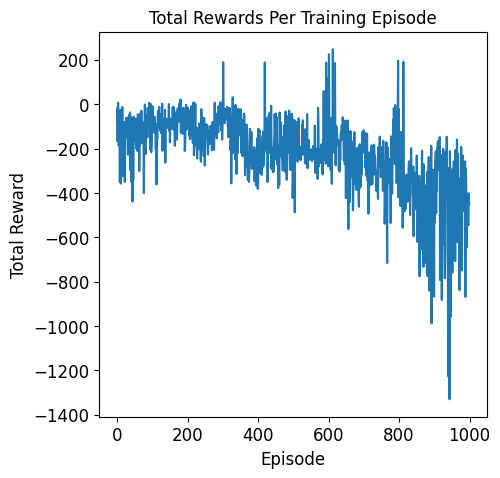

In [81]:
# show rewards change in training
# for i in range(len(train_rewards)):
    # if(len(train_rewards[i]) < n_episodes+100):  train_rewards[i] = np.concatenate((np.array(train_rewards[i]), np.repeat(200, 90 + n_episodes - len(train_rewards[i]))))#[-1:n_episodes+1000] = 200

expanded_train_rewards = np.array([rew if len(rew) >= n_episodes else np.concatenate((rew, np.repeat(200, n_episodes - len(rew)))) for rew in train_rewards])
plt.subplots(figsize = (5, 5), dpi=100)
y = np.mean(expanded_train_rewards, axis=0)
ci = 1.96 * np.std(expanded_train_rewards, axis=0)/np.sqrt(len(expanded_train_rewards[0]))

plt.plot(y)
plt.fill_between(range(len(expanded_train_rewards[0])), (y-ci), (y+ci), color='b', alpha=.1)

plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
plt.savefig(DDQN_RESULT_IMG_PATH.format(0), dpi=100, bbox_inches='tight')
plt.show()

### Evaluation

In [ ]:
test_episodes=100
test_reward_array = np.zeros(100)
agent = DDQN_Agent(n_states, 
                   n_actions, 
                   batch_size, 
                   hidden_size, 
                   memory_size, 
                   update_step, 
                   learning_rate, 
                   gamma, 
                   tau)
# load check point to restore the model
agent.policy_model.load_state_dict(
    torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))

t = trange(test_episodes, leave=True)
for episode in t: 
    state = env.reset()[0]
    done = False
    rewards = 0. 
    while not done: 
        # disable epsilon greedy search
        action = agent.act(state, epsilon=0) 
        state, reward, done, _, _ = env.step(action)
        rewards += reward
    t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
    t.refresh()
    test_reward_array[episode] = rewards
env.close()

In [ ]:
avg_test_reward = round(np.mean(test_reward_array), 2)
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(test_reward_array)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Trial', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), 
          fontsize=12)
# plt.savefig(DDQN_RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# take a look at how a DDQN agent act in the game
# On OS X, you can install ffmpeg via `brew install ffmpeg`. 
# On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. 
# On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

env = wrappers.Monitor(env, DDQN_AGENT_PATH, force=True)
state = env.reset()
done = False
rewards = 0.
while True:
    # disable epsilon greedy search
    action = agent.act(state, epsilon=0)
    state, reward, done, _ = env.step(action)
    rewards += reward
    if done:
        print('Total Rewards in this game: {:.2f}'.format(rewards))
        break
env.close()

# find video record under ./output/ddqn_agent

## Reference

1. Hasselt, H. V. (2010). Double Q-learning. In Advances in neural information processing systems (pp. 2613-2621).
2. Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.
3. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. arXiv preprint arXiv:1606.01540.

In [ ]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")


agent = DDQN_Agent(n_states, 
                   n_actions, 
                   batch_size, 
                   hidden_size, 
                   memory_size, 
                   update_step, 
                   learning_rate, 
                   gamma, 
                   tau)
# load check point to restore the model
agent.policy_model.load_state_dict(
    torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))
    
total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = agent.act(state, epsilon=0)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    env.render()
    if done:
        break

print("Episode done in %d steps, total reward %.2f.\nSaved recording to %s" % (
    total_steps, total_reward, DDQN_RESULT_IMG_PATH))
env.close()
env.env.close()

In [ ]:
# %pip install dm_env

In [ ]:
import itertools
import dm_env
from dm_env import specs
import numpy as np
from typing import Tuple


class Stimulus:
    def __init__(self, activation_length: int):
        self.active = False
        self.activation_length = activation_length
        self.onset = None
        self.activation_steps = 0

    def set_onset(self, onset):
        self.onset = onset

    def tick(self, time_step):
        if self.active:
            if self.activation_steps >= self.activation_length:
                self.active = False
                self.activation_steps = 0
            self.activation_steps += 1
        else:
            if self.onset == time_step:
                self.active = True
                self.activation_steps = 1

    def get_value(self):
        return int(self.active)


class TraceConditioning(dm_env.Environment):
    def __init__(self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float,
                 num_distractors: int, activation_lengths: dict):
        self.num_US = 1
        self.num_CS = 1

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma

        self.US = Stimulus(activation_lengths["US"])
        self.CS = Stimulus(activation_lengths["CS"])

        self.num_distractors = num_distractors
        self.distractors_probs = 1. / np.arange(10, 110, 10)
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.time_step = None
        self.trial_start = None
        self.rand_num_generator = np.random.RandomState(seed)

    def reset(self):
        self.time_step = 0
        self.trial_start = 0
        self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        self.CS.set_onset(self.time_step)
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.US.set_onset(self.time_step + ISI)
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def configure_distractors(self):
        for d, distractor in enumerate(self.distractors):
            if (not distractor.active) and self.rand_num_generator.rand() < self.distractors_probs[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        self.US.tick(self.time_step)
        self.CS.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        observations[1] = self.CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_US + self.num_CS] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class TracePatterning(dm_env.Environment):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):

        self.num_US = 1
        self.US = Stimulus(activation_lengths["US"])

        self.num_CS = num_CS
        self.CSs = [Stimulus(activation_lengths["CS"]) for _ in range(self.num_CS)]

        self.num_distractors = num_distractors
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.num_activation_patterns = num_activation_patterns
        self.activation_patterns_prob = activation_patterns_prob
        self.rand_num_generator = np.random.RandomState(seed)
        self.activation_patterns = produce_activation_patterns(self.rand_num_generator, self.num_CS,
                                                               self.num_activation_patterns)
        self.p = ((2 ** self.num_CS) * self.activation_patterns_prob - self.num_activation_patterns) / \
                 (2 ** self.num_CS - self.num_activation_patterns)

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma
        self.noise = noise

        self.time_step = None
        self.trial_start = None

    def reset(self):
        self.trial_start = 0
        self.time_step = 0
        self.configure_trial()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        CS_pattern = self.set_CSs()
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.set_US(ISI, CS_pattern)
        self.set_distractors()
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def set_CSs(self):
        if self.rand_num_generator.rand() < self.p:
            CS_pattern = self.activation_patterns[self.rand_num_generator.choice(self.num_activation_patterns), :]
        else:
            CS_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_CS)), dtype=float)
        for c, CS in enumerate(self.CSs):
            if CS_pattern[c] == 1:
                CS.set_onset(self.time_step)
        return CS_pattern

    def set_US(self, ISI, CS_pattern):
        if np.sum(binary_match(CS_pattern, self.activation_patterns)) > 0:
            if self.rand_num_generator.rand() > self.noise:
                self.US.set_onset(self.time_step + ISI)
        else:
            if self.rand_num_generator.rand() < self.noise:
                self.US.set_onset(self.time_step + ISI)

    def set_distractors(self):
        distractor_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_distractors)),
                                               dtype=float)
        for d, distractor in enumerate(self.distractors):
            if distractor_pattern[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        for c, CS in enumerate(self.CSs):
            CS.tick(self.time_step)
        self.US.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        for c, CS in enumerate(self.CSs):
            observations[c + 1] = CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_CS + self.num_US] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class NoisyPatterning(TracePatterning):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):
        super().__init__(seed, ISI_interval, ITI_interval, gamma, num_CS, num_activation_patterns,
                         activation_patterns_prob, num_distractors, activation_lengths, noise)
        self.ISI_interval = (activation_lengths["CS"], activation_lengths["CS"])


def compute_return_error(cumulants, predictions, gamma):
    num_time_steps = len(cumulants)
    returns = np.zeros(num_time_steps)
    returns[-1] = cumulants[-1]
    for t in range(num_time_steps - 2, -1, -1):
        returns[t] = gamma * returns[t + 1] + cumulants[t]
    return_error = (predictions - returns) ** 2
    MSRE = return_error.mean()
    return MSRE, return_error, returns


def produce_activation_patterns(rand_num_generator, num_CS, num_activation_patterns):
    activated_indices = list(itertools.combinations(np.arange(num_CS), int(num_CS / 2)))
    selected_indices = rand_num_generator.choice(np.arange(len(activated_indices)), size=num_activation_patterns,
                                                 replace=False)
    activation_patterns = np.zeros((num_activation_patterns, num_CS))
    for i in range(num_activation_patterns):
        activation_patterns[i, activated_indices[selected_indices[i]]] = 1.0
    return activation_patterns


def binary_match(x, patterns):
    if sum(x) == 0:
        ones_match = np.ones(patterns.shape[0])
    else:
        ones_match = np.floor(np.dot(patterns, x) / sum(x))
    if sum(1 - x) == 0:
        zeros_match = np.ones(patterns.shape[0])
    else:
        zeros_match = np.floor(np.dot(1 - patterns, 1 - x) / sum(1 - x))
    return ones_match * zeros_match